In [ ]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm.m
#

In [1]:
from kipet import KipetModel
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


In [2]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['Qf'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')

In [3]:
flow_df

,Qf,x
time,,
9.0,0.134365,4.7860
19.0,1.772804,14.2180
29.0,1.734587,13.9980
39.0,1.703319,13.8180
49.0,1.669967,13.6260
...,...,...
829.0,0.000990,4.0182
839.0,0.000782,4.0170
849.0,0.000643,4.0162


In [4]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [5]:
lc_data

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014
503,0.1042
513,0.1045
523,0.0970
533,0.0824


In [6]:
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = flow_df[['Qf']]
qinB_traj.columns = ['qin_B']
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [7]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

# here the total moles of A, B, and C are used
# though defined as state concentration, the ODEs are based on total moles
#
r1.add_component('A', state = 'concentration', init = 2.35)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)
r1.add_component('D', state = 'concentration', init = 0.0)

r1.add_component('V', state = 'state', init = 2370)

r1.add_algebraic_variables(['y', 'qin_B'])

r1.add_parameter('k1',init = 100, bounds=(0.0,10e3))
r1.add_parameter('k2',init = 100, bounds=(0.0,10e3))
r1.add_parameter('na0', init = 2.35, bounds = (0, 10))

cbf = 0.00721

In [8]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] / m.X[t, 'V']
    exprs['B'] = m.Y[t, 'qin_B'] * cbf - (m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] + m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'])/m.X[t, 'V']
    exprs['C'] = (m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] - m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'])/m.X[t, 'V']
    exprs['D'] = m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'] / m.X[t, 'V']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

r1.add_equations(rule_odes) 

In [9]:
def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t, 'y'] * (m.Z[t, 'C'] + 2 * m.Z[t, 'D']) - m.Z[t, 'C'])
    return r

r1.add_algebraics(rule_algebraics)

In [10]:
r1.add_objective_from_algebraic('y')

In [11]:
r1.add_dataset('lc_data', category = 'custom', data = lc_data)
r1.add_dataset('Traj', category = 'trajectory', data = qinB_traj)

In [12]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 900)

In [13]:
r1.settings.collocation.nfe = 60
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [14]:
r1.create_pyomo_model()

times are: <class 'tuple'>
0 900
 If this is the desired behavior, some algebraics must be added after the model is created.


In [15]:
# explicitly add constraints for initial conditions and relax the auto-imposed initial conditions by builder
r1.model.ca0_cons = pyo.Constraint(expr = r1.model.Z[0, 'A'] == r1.model.P['na0'])
r1.model.init_conditions_c['A'].deactivate()

In [16]:
r1.run_opt()

No variance information for A found, setting equal to unity
No variance information for B found, setting equal to unity
No variance information for C found, setting equal to unity
No variance information for D found, setting equal to unity
No variance information for V found, setting equal to unity
        0.29 seconds required to write file
        0.29 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     9549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in 

  82  2.8460086e-04 3.22e-03 7.65e-04  -8.6 1.63e+03    -  1.00e+00 1.00e+00h  1
  83  3.1293884e-04 1.73e-05 2.12e-05  -8.6 2.10e+00  -7.3 1.00e+00 1.00e+00h  1
  84  2.3088731e-04 3.09e-03 6.74e-04  -8.6 2.39e+03    -  1.00e+00 1.00e+00h  1
  85  2.5010819e-04 1.24e-05 1.23e-05  -8.6 2.77e-01  -6.8 1.00e+00 1.00e+00h  1
  86  2.0821628e-04 1.74e-03 3.64e-04  -8.6 3.50e+03    -  1.00e+00 7.60e-01h  1
  87  2.2614396e-04 3.42e-04 7.42e-05  -8.6 1.15e+03    -  1.00e+00 1.00e+00h  1
  88  2.2760890e-04 2.96e-07 6.68e-07  -8.6 2.84e-02  -6.4 1.00e+00 1.00e+00h  1
  89  2.1494700e-04 2.22e-04 4.20e-05  -8.6 4.25e+03    -  1.00e+00 2.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.1650811e-04 1.14e-04 2.15e-05  -8.6 2.24e+02    -  1.00e+00 5.00e-01h  2
  91  2.1615704e-04 3.72e-07 8.26e-08  -8.6 1.07e+02    -  1.00e+00 1.00e+00h  1
  92  2.1615958e-04 1.32e-12 8.19e-09  -8.6 6.47e-02  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 9

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 1989
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 1986
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 3
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601035646584638 at var_i=937
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601035646948057 at var_i=938
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 1986, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 9549
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 2557
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000216
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 1774
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[


RESULTS
Z:
                    A             B             C             D
0.000000    2.335231  3.141208e-18  5.632110e-18  2.748104e-18
2.005973    2.333740  2.169482e-05  1.486326e-03  4.344235e-06
8.344027    2.333836  8.672349e-05  1.401047e-03 -6.552987e-06
12.937500   2.320723  5.555435e-04  1.448569e-02  2.218466e-05
14.943473   2.307564  8.063234e-04  2.762132e-02  4.561079e-05
...              ...           ...           ...           ...
878.319184  0.001484  1.705651e-05  1.802122e-01  2.153535e+00
884.000000  0.001484  1.703801e-05  1.801882e-01  2.153559e+00
886.480816  0.001483  1.702356e-05  1.801778e-01  2.153570e+00
894.319184  0.001483  1.700890e-05  1.801447e-01  2.153604e+00
900.000000  0.001482  1.701066e-05  1.801207e-01  2.153628e+00

[181 rows x 4 columns]

X:
                       V
0.000000    2370.000000
2.005973    2370.210362
8.344027    2370.204530
12.937500   2372.092317
14.943473   2373.955460
...                 ...
878.319184  2992.371522
884.000000

In [17]:
r1.results.show_parameters


The estimated parameters are:
k1 9995.090607288352
k2 4199.31407408505
na0 2.335230909100081


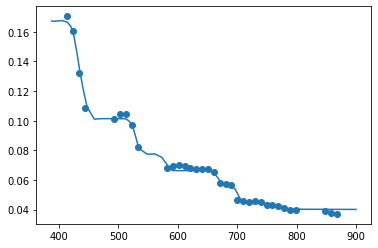

In [18]:
fig, ax = plt.subplots()
dfplt = r1.results.Y[r1.results.Y.index >= 380]
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(dfplt.index, dfplt['y'])

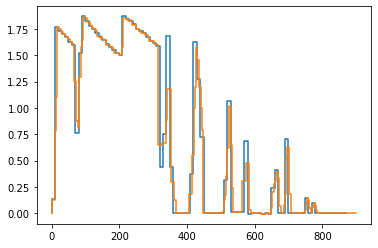

In [19]:
fig, ax = plt.subplots()
ax.step(qinB_traj.index, qinB_traj['qin_B'])
ax.step(r1.results.Y.index, r1.results.Y['qin_B'])

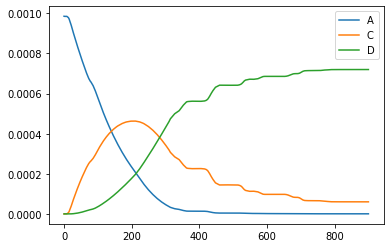

In [21]:
fig, ax = plt.subplots()
for c in ['A', 'C', 'D']:
    conc = r1.results.Z[c] / r1.results.X['V']
    ax.plot(r1.results.Z.index, conc, label = c)
ax.legend()

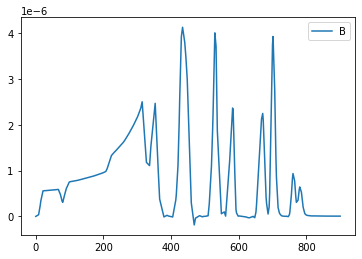

In [22]:
fig, ax = plt.subplots()
for c in ['B']:
    conc = r1.results.Z[c] / r1.results.X['V']
    ax.plot(r1.results.Z.index, conc, label = c)
ax.legend()

In [ ]:
dof = lc_data.shape[0] - 3
mse = r1.results.objective / dof
cov_mat = 2 * mse * r1.results.parameter_covariance
cov_mat

In [ ]:
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_mat))
conf_delta